# Single Image Rendering

This notebook demonstrates how to solve the Radiative Transfer using SHDOM and render a single image. 

The image rendered is monochromatic - a single wavelength for which a mie table was previously calculated.

---

Related tutorials: 
 - Make Mie Table.ipynb - how to create mie tables
 - Radiance Rendering [Multispectral].ipynb - how to create RGB (multispectral) images
 - Radiance Rendering [Multiview].ipynb - how to create multi-view images

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shdom
from mayavi import mlab # if it fails, use (comandline) jupyter nbextension enable mayavi --user --py 
# mlab.init_notebook()

In [2]:
""" 
 - MiePolydisperse object loads a previously saved mie table.
 - Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
   Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL [1]
 - A Large-Eddy-Simulated [2] cloud michrophysical properties are loaded from a csv file.

[1] G. P. Anderson, S. A. Clough, F. Kneizys, J. H. Chetwynd, and E. P. Shettle. 
    AFGL atmospheric constituentprofiles (0.120 km). Technical report, Air Force Geophysics Lab, 1986.
[2] G. Matheou and D. Chung. Large-eddy simulation of stratified turbulence. 
    part CLARREO: Application of thestretched-vortex model to the atmospheric boundary layer.
    Journal of the Atmospheric Sciences, 71(12):44394460,2014.
"""
# Mie scattering for water droplets
mie = shdom.MiePolydisperse()
mie.read_table(file_path='../mie_tables/polydisperse/Water_672nm.scat')

# Generate a Microphysical medium
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)

droplets.add_mie(mie)

# Rayleigh scattering for air molecules up to 20 km
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
rayleigh = shdom.Rayleigh(wavelength=0.672)
rayleigh.set_profile(temperature_profile.resample(air_grid))
air = rayleigh.get_scatterer()

Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat


Vadim add visualization of 3d fields

In [3]:

# use mlab.init_notebook() if you want to disply mlab here.
Grid_bounding_box = droplets.bounding_box
Grid_shape = droplets.grid.shape
xgrid = np.linspace(Grid_bounding_box.xmin, Grid_bounding_box.xmax,Grid_shape[0])
ygrid = np.linspace(Grid_bounding_box.ymin, Grid_bounding_box.ymax,Grid_shape[1])
zgrid = np.linspace(Grid_bounding_box.zmin, Grid_bounding_box.zmax,Grid_shape[2])   
X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
LWC_MAT = droplets.lwc.data;
scf = mlab.pipeline.scalar_field(X, Y, Z,LWC_MAT)
figh = mlab.gcf()
mlab.pipeline.volume(scf, figure=figh,vmin=0.0,vmax=1.24) # no working on servers
isosurface = mlab.pipeline.iso_surface(scf, contours=[0.0001],color = (1, 1,1),opacity=0.1,transparent=True)
mlab.pipeline.volume(isosurface, figure=figh)
mlab.pipeline.image_plane_widget(scf,plane_orientation='z_axes',slice_index=10)
                            
# figh.scene.anti_aliasing_frames = 0
mlab.scalarbar()
mlab.axes(figure=figh, xlabel="x (km)", ylabel="y (km)", zlabel="z (km)") 
mlab.show()

In [4]:
"""
Generate an Medium with two type of scatterers and initilize an RteSolver object. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values which can be viewed using print(params.info).
"""
atmospheric_grid = droplets.grid + air.grid # Add two grids by finding the common grid which maintains the higher resolution grid.
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')

numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=mie.wavelength,
    source=shdom.SolarSource(azimuth=65, zenith=135)
)

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.set_medium(atmosphere)

print(rte_solver.info)

--- the wantmem variable before REDUCE is 274059000.0, memory usage is 1096236000.0
--- the wantmem variable after REDUCE is 274059000.0, memory usage is 1096236000.0
--- the wantmem variable after REDUCE in Mib is 1149.4867599359998
--- The memory is being used per voxel is 20575.0
---  SYSTEM MAX SIZE is 9223372036854775807
--- MAXIG	max number of internal grid points is 266400
--- MAXIC	max number of grid cells, between 1 and 2 times grid points is 399600
--- MAXIV	max words for source function and radiance arrays; needed size is average spherical harmonic truncation times number of grid points is 85248000
--- MAXIDO	max words for temporary discrete ordinate azimuthal array; needed size is max azimuths times number of grid points. is 4262400
--- MAXIR	The RADIANCE defined by RADIANCE(MAXIV+MAXIG). MAXIR is 85514400
--- NLM    spherical harmonic terms is 64
--- ADAPTIVE GRID FACTOR    ratio of the max number of internal grid points to the number of base grid points is 5.0
---  CELL_T

In [5]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (src/unpolarized/shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solver.solve(maxiter=100)

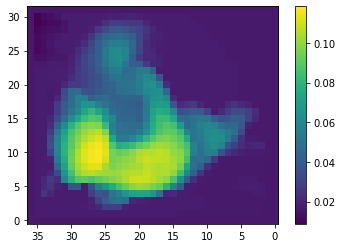

In [6]:
"""
Render an image by integrating the incoming radiance along the projection geometry defines (pixels).
"""
projection = shdom.OrthographicProjection(
    bounding_box=droplets.grid.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)
camera = shdom.Camera(shdom.RadianceSensor(), projection)
image = camera.render(rte_solver)

%matplotlib inline
plt.imshow(image)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.colorbar()